# 1. download  Libraries and data

In [1]:
!pip install pyspark tensorflow opencv-python-headless kaggle



In [4]:
# Authenticate Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle competitions download -c histopathologic-cancer-detection
!unzip -q histopathologic-cancer-detection.zip -d cancer_data


100% 6.31G/6.31G [04:15<00:00, 29.6MB/s]
100% 6.31G/6.31G [04:15<00:00, 26.5MB/s]


# 2. Preprocess and clean data if necessary




*   Data Description \
In this dataset, there is a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. we are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.




In [5]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

train_path = '/content/cancer_data/train/'
test_path = '/content/cancer_data/test/'
data = pd.read_csv('/content/cancer_data/train_labels.csv')


In [6]:
data.shape

(220025, 2)

* Check for duplicates

In [7]:
data[data.duplicated(keep=False)] # no duplicates in this case

,id,label


* Target Featuring \
0 : non cancer \
1 : cancer detection

In [8]:
data['label'].value_counts()

,count
label,
0,130908
1,89117


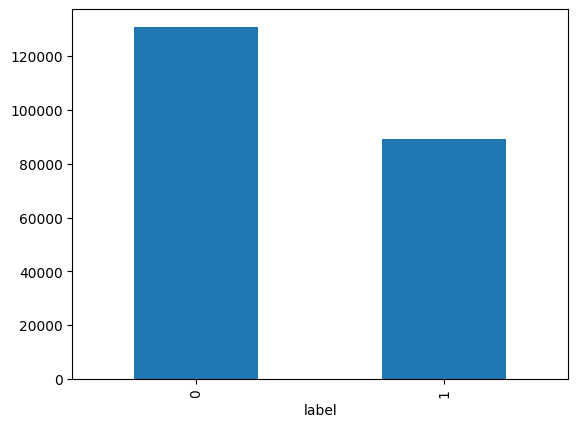

In [14]:
data['label'].value_counts().plot(kind='bar')
plt.show()


* Visualize Data

In [9]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

Text(0, 0.5, 'Tumor tissue samples')

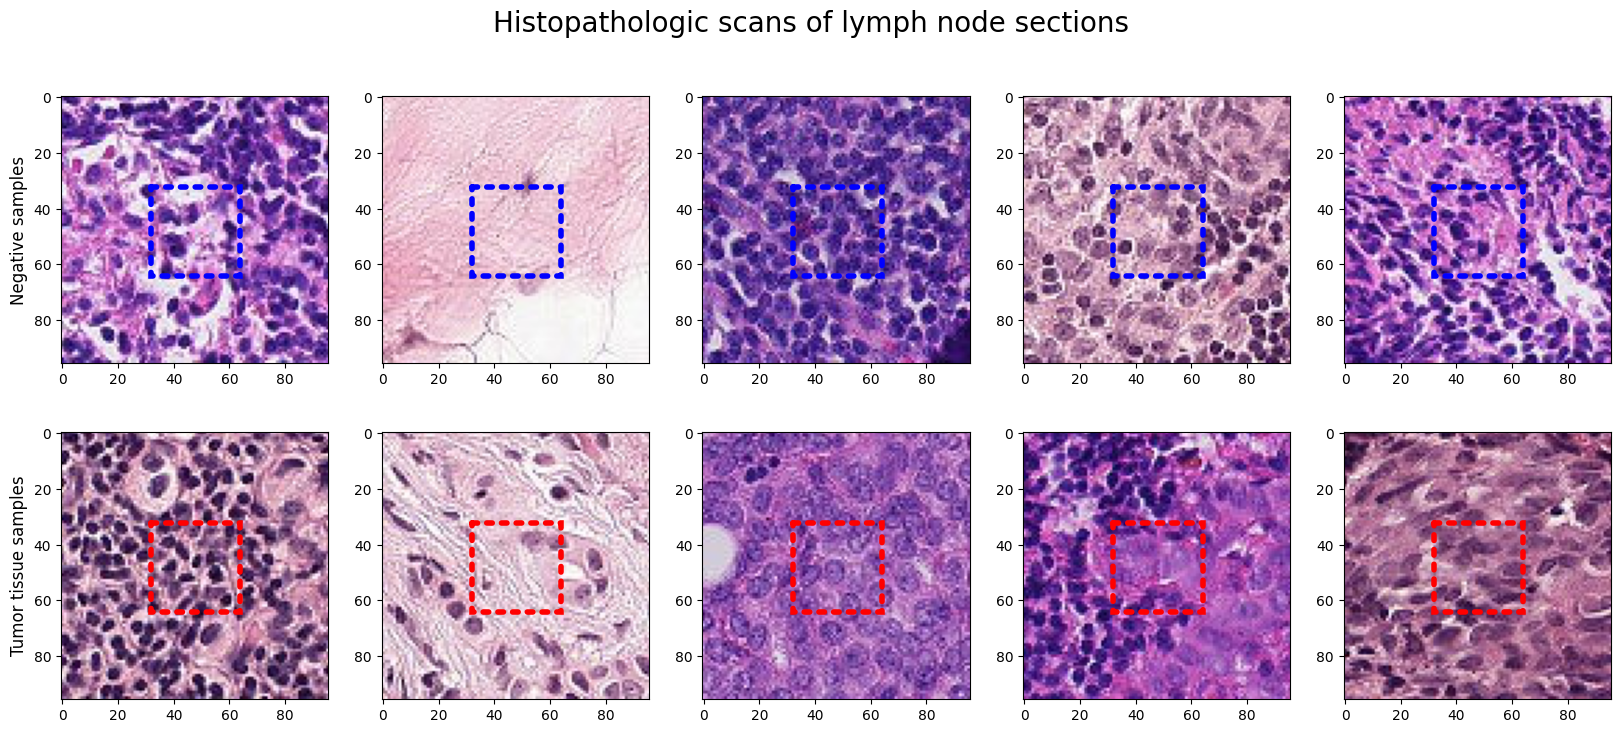

In [10]:
# random sampling
shuffled_data = shuffle(data)

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

Text(0, 0.5, 'Tumor tissue samples')

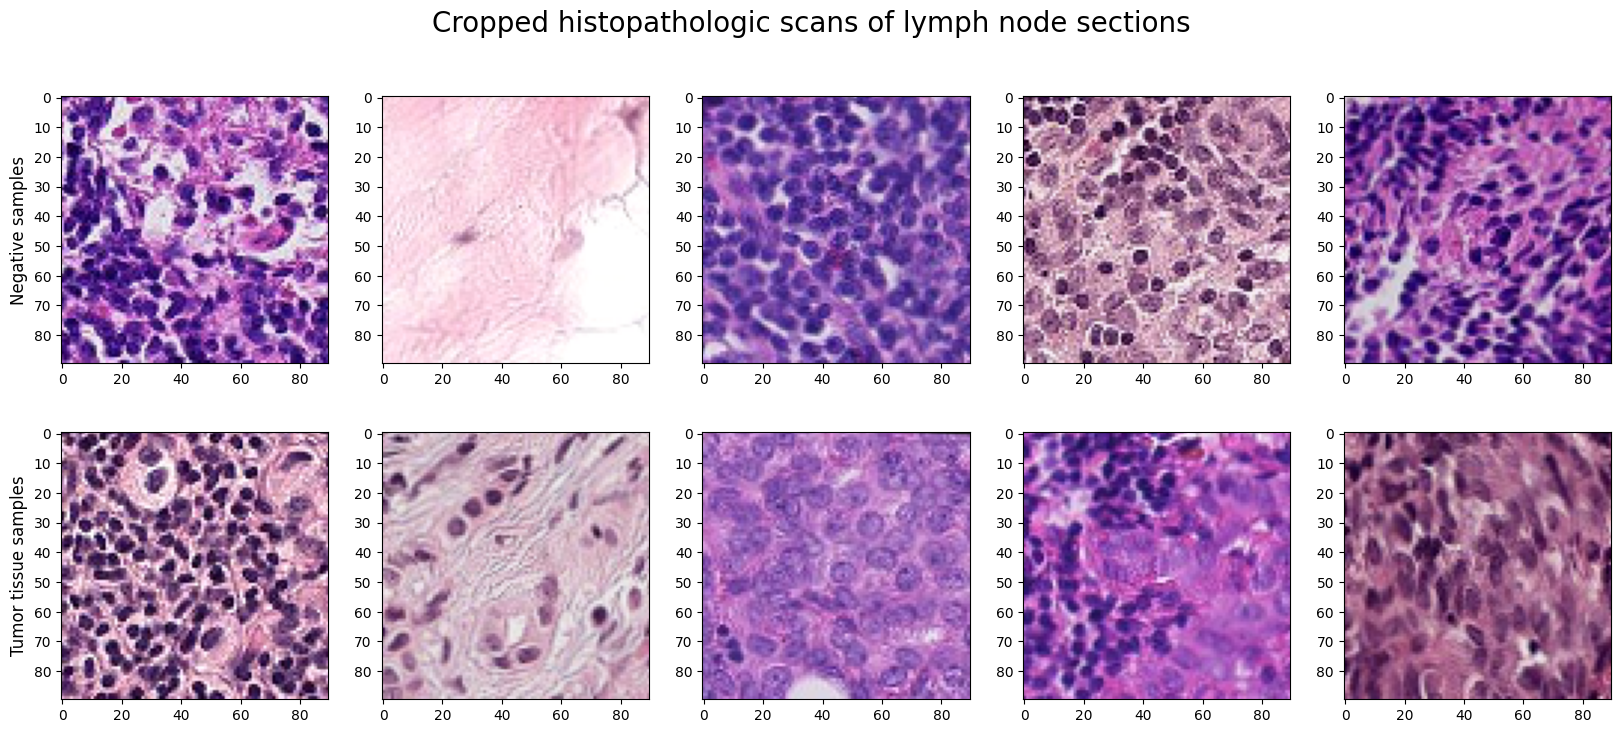

In [12]:
fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Cropped histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readCroppedImage(path + '.tif'))
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readCroppedImage(path + '.tif'))
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

In [13]:
# As we count the statistics, we can check if there are any completely black or white images
dark_th = 10 / 255      # If no pixel reaches this threshold, image is considered too dark
bright_th = 245 / 255   # If no pixel is under this threshold, image is considerd too bright
too_dark_idx = []
too_bright_idx = []

x_tot = np.zeros(3)
x2_tot = np.zeros(3)
counted_ones = 0
for i, idx in tqdm_notebook(enumerate(shuffled_data['id']), 'computing statistics...(220025 it total)'):
    path = os.path.join(train_path, idx)
    imagearray = readCroppedImage(path + '.tif', augmentations = False).reshape(-1,3)
    # is this too dark
    if(imagearray.max() < dark_th):
        too_dark_idx.append(idx)
        continue # do not include in statistics
    # is this too bright
    if(imagearray.min() > bright_th):
        too_bright_idx.append(idx)
        continue # do not include in statistics
    x_tot += imagearray.mean(axis=0)
    x2_tot += (imagearray**2).mean(axis=0)
    counted_ones += 1

channel_avr = x_tot/counted_ones
channel_std = np.sqrt(x2_tot/counted_ones - channel_avr**2)
channel_avr,channel_std

<ipython-input-13-2fd638ce4e23>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, idx in tqdm_notebook(enumerate(shuffled_data['id']), 'computing statistics...(220025 it total)'):


computing statistics...(220025 it total): 0it [00:00, ?it/s]

KeyboardInterrupt: 

* Check for bad images: that has no information

In [ ]:
print('There was {0} extremely dark image'.format(len(too_dark_idx)))
print('and {0} extremely bright images'.format(len(too_bright_idx)))
print('Dark one:')
print(too_dark_idx)
print('Bright ones:')
print(too_bright_idx)

these variables are insignificant compared to the size of our data but it is best to remove the outliers

In [ ]:
data = data.set_index('id')
data = data.drop(labels=too_dark_idx, axis=0)
data = data.drop(labels=too_bright_idx, axis=0)
print('After removing outliers we have {0} training samples.'.format(data.shape[0]))

# Balance Data (Down Sampling)
we have an imbalanced dataset (significantly more images of healthy tissue (130k) than cancerous tissue(89k), downsampling can help by reducing the majority class to match the size of the minority class.

In [16]:
data_0=data[data["label"] == 0].sample(89117, random_state=42)

In [17]:
data_1=data[data["label"] == 1]

In [18]:
df=pd.concat([data_0,data_1])

In [21]:
df['label'].value_counts()

,count
label,
0,89117
1,89117


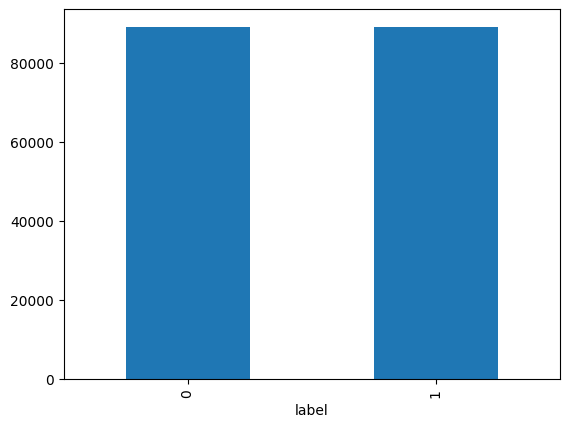

In [22]:
df['label'].value_counts().plot(kind='bar')
plt.show()


In [26]:
df

,id,label
121450,941ffe73059292e0effd4e81ca9363c117afc2f4,0
38268,43b6acadb31161c9281460efa3fad0b992a92837,0
158080,64cfb56ddf41e2a871ac5164d61e50b238b9ed1b,0
154803,9464cf403653088420cdb78acacd8cf7fa2255e4,0
93791,346bc5b2d383d70dfccb8fe9102c7f55687f5f52,0
...,...,...
220010,8a25b1632a1859d7b757e912ca673385b64e1b1d,1
220012,3e24dd48c3a419f4d669cac3cf71e777ba100541,1
220014,309210db7f424edbc22b2d13bf2fa27518b18f5c,1
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1


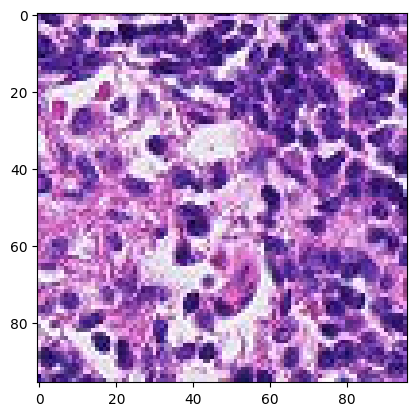

In [33]:
import matplotlib.pyplot as plt
import os


image_id = shuffled_data['id'].iloc[0]  # Get the first image ID
image_path = os.path.join(train_path, f'{image_id}.tif')

if os.path.exists(image_path):
    img = readImage(image_path)
    plt.imshow(img)
    plt.axis('on')
    plt.show()
else:
    print(f"Image file not found: {image_path}")

In [34]:
img.shape


(96, 96, 3)

**Preprocessing and augmentation**\
we are going to use minimal augmentations to enhance variability without overburdening computational resources, as we have a very big database (89k*2)\
for the augmentation : \
* Rotation: ±10° to account for slight orientation changes.
* Zooming: ±10% to simulate varying scan distances.
* Horizontal Flipping: To introduce left-right symmetry (if applicable).
* Brightness Adjustment: To handle lighting variations.

In [45]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_and_augment_images(data, images_dir, target_size=(96, 96), batch_size=32):
    # Define data augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,           # Normalize pixel values to [0, 1]
        rotation_range=10,        # Rotate images up to ±10 degrees
        zoom_range=0.1,           # Zoom in/out by 10%
        horizontal_flip=True,     # Flip images horizontally
        brightness_range=[0.8, 1.2],  # Adjust brightness
        validation_split=0.2      # Reserve 20% for validation
    )

    def process_batch(batch_df):
        images = []
        labels = []

        # Loop through each row in the batch and load the image
        for _, row in batch_df.iterrows():
            # Construct the full image path
            image_path = os.path.join(images_dir, row['id']) + '.tif'
            # Load the image, resize, and convert to array
            image = load_img(image_path, target_size=target_size)
            image = img_to_array(image)
            images.append(image)
            labels.append(row['label'])

        # Convert lists to numpy arrays
        images = np.array(images)
        labels = np.array(labels)

        # Apply augmentation on the images and return
        return train_datagen.flow(images, labels, batch_size=batch_size)

    # Generator to yield augmented batches
    def generator():
        batch_size = 32
        for i in range(0, len(data), batch_size):
            batch_df = data.iloc[i:i + batch_size]
            # Yield the batch from process_batch
            augmented_data = process_batch(batch_df)
            for batch_images, batch_labels in augmented_data:
                yield batch_images, batch_labels  # Yield augmented images and labels

    return generator

images_dir = train_path
train_generator = load_and_augment_images(df, images_dir)

# Test the generator
for batch_images, batch_labels in train_generator():
    print(f"Batch images shape: {batch_images.shape}")
    print(f"Batch labels shape: {batch_labels.shape}")
    break  # Only get the first batch


Batch images shape: (32, 96, 96, 3)
Batch labels shape: (32,)


# 3. Prepare Data for training

* Prepare the data and split train

In [32]:
img.shape

(96, 96, 3)

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Define the CNN model
def create_efficient_cnn_model(input_shape=(96, 96, 3)):
    model = Sequential([
        # First Conv Block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Second Conv Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Third Conv Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Fourth Conv Block (bottleneck)
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Global Average Pooling to reduce the number of parameters
        GlobalAveragePooling2D(),

        # Fully connected layers
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    # Compile the model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create the model
cnn_model = create_efficient_cnn_model()

# Model summary to check the parameters
cnn_model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 96, 96, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 423,361 (1.61 MB)

 Trainable params: 422,401 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [47]:
cnn_model.fit(train_generator(), steps_per_epoch=len(df) // 32, epochs=10)

Epoch 1/10
 133/5569 ━━━━━━━━━━━━━━━━━━━━ 2:00:02 1s/step - accuracy: 0.9665 - loss: 0.0642

KeyboardInterrupt: 

## Test other batch_size and epochs

In [ ]:
cnn_model.fit(train_generator(), steps_per_epoch=len(df) // 32, epochs=5)  # Using 5 epochs for faster testing


Epoch 1/5
3205/5569 ━━━━━━━━━━━━━━━━━━━━ 49:15 1s/step - accuracy: 1.0000 - loss: 2.5787e-05

In [ ]:
cnn_model.fit(train_generator(), steps_per_epoch=len(df) // 16, epochs=10)


In [ ]:
d_test=pd.read_csv('/content/cancer_data/sample_submission.csv')
# Assuming you have a validation generator
validation_generator = load_and_augment_images(d_test, test_path)

# Evaluate the model on the validation set
loss, accuracy = cnn_model.evaluate(validation_generator(), steps=len(df) // 32)

print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")


In [ ]:
# Save the trained model to a file
cnn_model.save('cnn_model.h5')  # Saves the model as a .h5 file


# Model 2 : EfficientNetB0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=base_model.input, outputs=output)


# Model 3 : VGG16

In [ ]:

train_generator = load_and_augment_images(df, images_dir)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_vgg16_model(input_shape=(96, 96, 3)):
    # Load the VGG16 model pre-trained on ImageNet without the top layer (fully connected layers)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of VGG16 to avoid training them
    for layer in base_model.layers:
        layer.trainable = False

    # Build the custom model on top of VGG16
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),  # Adding a dense layer with 256 units
        Dropout(0.5),  # Dropout for regularization
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    # Compile the model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the VGG16-based model
vgg16_model = create_vgg16_model()


In [ ]:
# Train the model using the train_generator
vgg16_model.fit(train_generator(), steps_per_epoch=len(df) // 32, epochs=10)


In [ ]:
# Create the test generator (no augmentation, just rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)  # Rescaling the pixel values

# Test generator that loads the images from the test directory
test_generator = test_datagen.flow_from_directory(
    test_path,                          # Path to the test directory
    target_size=(96, 96),              # Resize to match input size of the model
    batch_size=32,                     # Use the same batch size as during training
    class_mode='binary',               # Binary classification
    shuffle=False                      # Don't shuffle the test data
)

# Evaluate the model on the test set
loss, accuracy = vgg16_model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

# Print the evaluation results
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


In [ ]:
# Save the trained model
vgg16_model.save('vgg16_cnn_model.h5')


# Model 4: EfficientNetB0

In [ ]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load and preprocess your data generator
def load_and_augment_images(data, images_dir, target_size=(96, 96), batch_size=32):
    # Define data augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,           # Normalize pixel values to [0, 1]
        rotation_range=10,        # Rotate images up to ±10 degrees
        zoom_range=0.1,           # Zoom in/out by 10%
        horizontal_flip=True,     # Flip images horizontally
        brightness_range=[0.8, 1.2],  # Adjust brightness
        validation_split=0.2      # Reserve 20% for validation
    )

    def process_batch(batch_df):
        images = []
        labels = []

        for _, row in batch_df.iterrows():
            # Construct the full image path
            image_path = os.path.join(images_dir, row['id']) + '.tif'
            # Load image and resize to (96, 96)
            image = load_img(image_path, target_size=target_size)
            image = img_to_array(image)
            images.append(image)
            labels.append(row['label'])

        # Convert images and labels to numpy arrays
        images = np.array(images)
        labels = np.array(labels)

        # Apply augmentation on the images
        return train_datagen.flow(images, labels, batch_size=batch_size)

    # Generator for batches
    def generator():
        batch_size = 32
        # Process the data in batches
        for i in range(0, len(data), batch_size):
            batch_df = data.iloc[i:i + batch_size]
            # Yield the augmented data from process_batch
            yield process_batch(batch_df)

    return generator

# Build the EfficientNetB0 model with transfer learning
def create_efficientnet_model(input_shape=(96, 96, 3), num_classes=1):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of the base model (transfer learning)
    base_model.trainable = False

    # Add custom layers for classification
    model = Model(inputs=base_model.input, outputs=[
        GlobalAveragePooling2D()(base_model.output),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')  # Binary classification output
    ])

    # Compile the model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the EfficientNetB0 model
efficientnet_model = create_efficientnet_model()
